# Setup

In [353]:
import numpy as np
import seaborn as sns
import pandas as pd
import glob
from sklearn.metrics import accuracy_score

# Functions

## File handling

In [46]:
def read_csv(filepath, cols, names):
    df = pd.read_csv(filepath, usecols = cols, names = names, header = None)
    df = df.drop([0], axis = 0) # Remove first row (headers)
    df = df.astype('float64') # Cast data to floats
    
    return df

In [47]:
def get_class_df(file_path, df):
    class_name = '_'.join(file_path.split('\\')[-1].split('_')[:-1])

    return pd.DataFrame({'class': [class_name for _ in range(len(df))]})

In [48]:
def read_acc_mag_csvs():
    X = pd.DataFrame()
    y = pd.DataFrame(columns=['class'])
    
    for file in glob.glob('data/cleaned/acc_mag/*.csv'):

        if 'acc' in file.split('\\')[-1]:
            mag_file = file.replace(file.split('\\')[-1], file.split('\\')[-1].replace('acc', 'mag'))
            
            df_acc = read_csv(file, [1,2,3], ['ax', 'ay', 'az'])
            df_mag = read_csv(mag_file, [1,2,3], ['mx', 'my', 'mz'])
            
            df = pd.concat([df_acc, df_mag], axis=1, join='inner')
            X = X.append(df, ignore_index=True)            

            y = y.append(get_class_df(file, df), ignore_index=True)

    return X, y

In [477]:
def read_acc_mag_gyro_csvs(set, acc = True, mag = True, gyro = True):
    X = pd.DataFrame()
    y = pd.DataFrame(columns=['class'])
    
    for file in glob.glob('data/cleaned/acc_mag_gyro/' + set + '/*.csv'):

        if acc or mag or gyro:
            if 'acc' in file.split('\\')[-1]:
                dfs = []
                
                if acc:
                    df_acc = read_csv(file, [1,2,3], ['ax', 'ay', 'az'])
                    dfs.append(df_acc)
                if mag:
                    mag_file = file.replace(file.split('\\')[-1], file.split('\\')[-1].replace('acc', 'mag'))
                    df_mag = read_csv(mag_file, [1,2,3], ['mx', 'my', 'mz'])
                    dfs.append(df_mag)
                if gyro:
                    gyro_file = file.replace(file.split('\\')[-1], file.split('\\')[-1].replace('acc', 'gyro'))
                    df_gyro = read_csv(gyro_file, [1,2,3], ['gx', 'gy', 'gz'])
                    dfs.append(df_gyro)
                
                df = pd.concat(dfs, axis=1, join='inner')
                X = X.append(df, ignore_index = True)
                
                y = y.append(get_class_df(file, df), ignore_index=True)
        
    return X, y

In [50]:
def get_filepaths_from_folder(path, filter=''):
    files = []
    
    for file in glob.glob(path + '*'):
        if filter in file.split('\\')[-1]:
            files.append(file)
        
    return files

## Classifiers and metrics

In [234]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

def train_knn(X, y):
    #create a dictionary of all values we want to test for n_neighbors
    param_grid = {'n_neighbors': np.arange(1, 60)}

    #use gridsearch to test all values for n_neighbors
    knn_gscv = GridSearchCV(KNeighborsClassifier(), param_grid, cv = 5, n_jobs=-1)

    #fit model to data
    knn_gscv.fit(X, y.values.ravel())

    print('Best k:\t', knn_gscv.best_params_)
    print('Score:\t', knn_gscv.best_score_)

    return knn_gscv

In [276]:
from sklearn.metrics import confusion_matrix

def print_conf_matrix(X, y, classifier):
    conf_matrix = confusion_matrix(y, classifier.predict(X))
    print(classifier.classes_)
    print(conf_matrix)

## Math

In [526]:
def calc_norms(df):
    l = []
    
    for i in range(len(df)):
        l.append(np.linalg.norm(df.iloc[i]))
        
    return pd.DataFrame({'Norm': l})

In [527]:
def calc_angle(df, axis, i):
    return np.rad2deg(np.arccos(df[axis].iloc[i] / np.linalg.norm(df.iloc[i])))

In [528]:
def calc_angles(df, axis):
    l = []
    
    for i in range(len(df)):
        l.append(calc_angle(df, axis, i))
        
    return pd.DataFrame({'Angle': l})

# Prepare data

## Trim

### Functions

In [51]:
def inspect_acc_mag_gyro_data(df_acc, df_mag, df_gyro):
    df_acc.plot(kind = "line", title='Inspection of raw acc data', figsize=(15,3))
    df_mag.plot(kind = "line", title='Inspection of raw mag data', figsize=(15,3))
    df_gyro.plot(kind = "line", title='Inspection of raw gyro data', figsize=(15,3))

In [72]:
def remove_junk_data(df_acc, df_mag, df_gyro, lower, upper):
    upper = upper - lower

    # Remove lower part
    df_acc = df_acc.drop(df_acc.index[:lower], axis=0)
    df_mag = df_mag.drop(df_mag.index[:lower//10], axis=0)
    df_gyro = df_gyro.drop(df_gyro.index[:lower], axis=0)

    # Remove upper part
    df_acc = df_acc.drop(df_acc.index[upper:], axis=0)
    df_mag = df_mag.drop(df_mag.index[upper//10:], axis=0)
    df_gyro = df_gyro.drop(df_gyro.index[upper:], axis=0)

    return df_acc, df_mag, df_gyro

In [53]:
def save_changes(df_acc, df_mag, df_gyro):
    cleaned_acc_filepath = raw_data_filepaths[index].replace('raw', 'cleaned')
    cleaned_mag_filepath = mag_filepath.replace('raw', 'cleaned')
    cleaned_gyro_filepath = gyro_filepath.replace('raw', 'cleaned')

    with open(cleaned_acc_filepath, 'w') as f:
        f.close()
    df_acc.to_csv(cleaned_acc_filepath)

    with open(cleaned_mag_filepath, 'w') as f:
        f.close()
    df_mag.to_csv(cleaned_mag_filepath)

    with open(cleaned_gyro_filepath, 'w') as f:
        f.close()
    df_gyro.to_csv(cleaned_gyro_filepath)

    print('Cleaned data written to:')
    print(cleaned_acc_filepath)
    print(cleaned_mag_filepath)
    print(cleaned_gyro_filepath)

### Inspection and removal of junk data

Get filepaths:

In [550]:
raw_data_filepaths = get_filepaths_from_folder('data/raw/acc_mag_gyro/', filter='acc')
raw_data_filepaths

['data/raw/acc_mag_gyro\\jump_acc1.csv',
 'data/raw/acc_mag_gyro\\jump_acc2.csv',
 'data/raw/acc_mag_gyro\\jump_acc3.csv',
 'data/raw/acc_mag_gyro\\jump_acc4.csv',
 'data/raw/acc_mag_gyro\\jump_acc5.csv',
 'data/raw/acc_mag_gyro\\jump_acc6.csv',
 'data/raw/acc_mag_gyro\\pushup_acc1.csv',
 'data/raw/acc_mag_gyro\\pushup_acc2.csv',
 'data/raw/acc_mag_gyro\\pushup_acc3.csv',
 'data/raw/acc_mag_gyro\\pushup_acc4.csv',
 'data/raw/acc_mag_gyro\\pushup_acc5.csv',
 'data/raw/acc_mag_gyro\\pushup_acc6.csv',
 'data/raw/acc_mag_gyro\\run_acc1.csv',
 'data/raw/acc_mag_gyro\\run_acc2.csv',
 'data/raw/acc_mag_gyro\\run_acc3.csv',
 'data/raw/acc_mag_gyro\\run_acc4.csv',
 'data/raw/acc_mag_gyro\\run_acc5.csv',
 'data/raw/acc_mag_gyro\\run_acc6.csv',
 'data/raw/acc_mag_gyro\\walk_acc1.csv',
 'data/raw/acc_mag_gyro\\walk_acc2.csv',
 'data/raw/acc_mag_gyro\\walk_acc3.csv',
 'data/raw/acc_mag_gyro\\walk_acc4.csv',
 'data/raw/acc_mag_gyro\\walk_acc5.csv',
 'data/raw/acc_mag_gyro\\walk_acc6.csv']

Index in file list to work with:

In [548]:
index = 10

Read and inspect data:

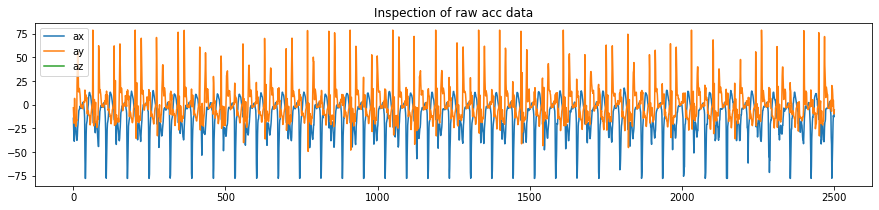

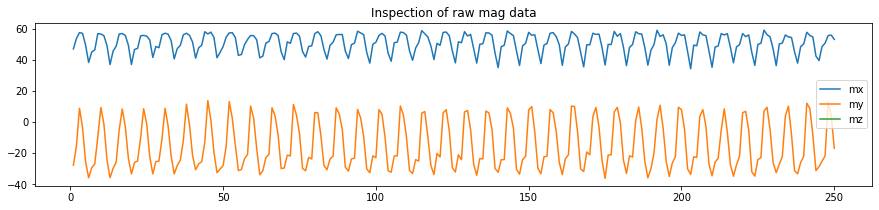

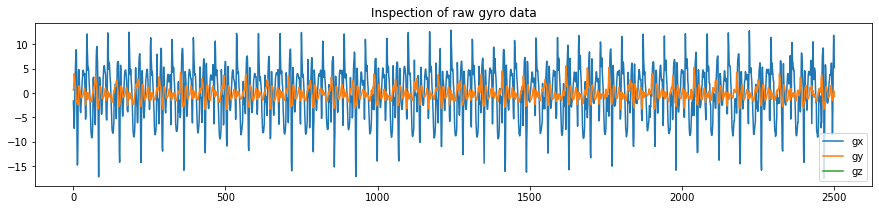

In [549]:
mag_filepath = 'mag'.join(raw_data_filepaths[index].rsplit('acc', 1))
gyro_filepath = 'gyro'.join(raw_data_filepaths[index].rsplit('acc', 1))

df_acc_raw = read_csv(raw_data_filepaths[index], [2,3,4], ['ax', 'ay', 'az'])
df_mag_raw = read_csv(mag_filepath, [2,3,4], ['mx', 'my', 'mz'])
df_gyro_raw = read_csv(gyro_filepath, [2,3,4], ['gx', 'gy', 'gz'])

inspect_acc_mag_gyro_data(df_acc_raw, df_mag_raw, df_gyro_raw)

Inspect data:

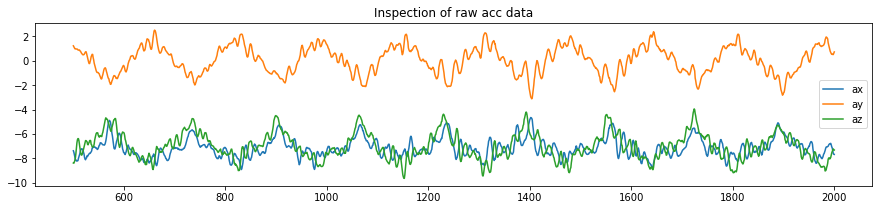

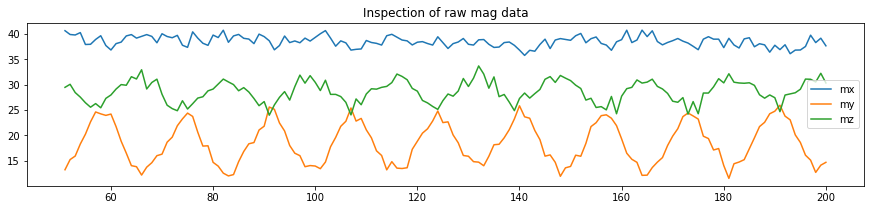

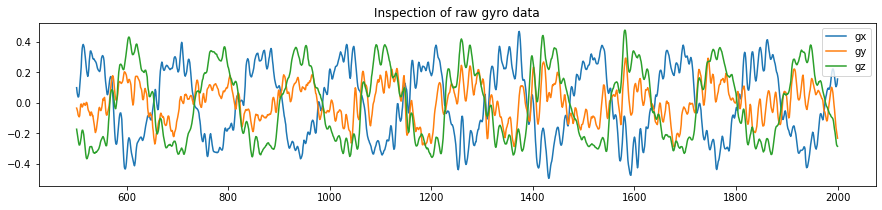

In [401]:
df_acc_clean, df_mag_clean, df_gyro_clean = remove_junk_data(df_acc_raw, df_mag_raw, df_gyro_raw, lower=500, upper=2000)
inspect_acc_mag_gyro_data(df_acc_clean, df_mag_clean, df_gyro_clean)

In [210]:
save_changes(df_acc_clean, df_mag_clean, df_gyro_clean)

Cleaned data written to:
data/cleaned/acc_mag_gyro/all\run_walk_jump_pushup_acc2.csv
data/cleaned/acc_mag_gyro/all\run_walk_jump_pushup_mag2.csv
data/cleaned/acc_mag_gyro/all\run_walk_jump_pushup_gyro2.csv


## Read files and split into training and test set

In [530]:
X_train, y_train = read_acc_mag_gyro_csvs('train', acc=True, mag=False, gyro=True)
X_test, y_test = read_acc_mag_gyro_csvs('test', acc=True, mag=False, gyro=True)

In [282]:
# Not suitable in this case
#from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(X_acc_gyro, y_acc_gyro, test_size=0.2, random_state=42, shuffle=False)

## Preprocess

# Tasks

## A first classification

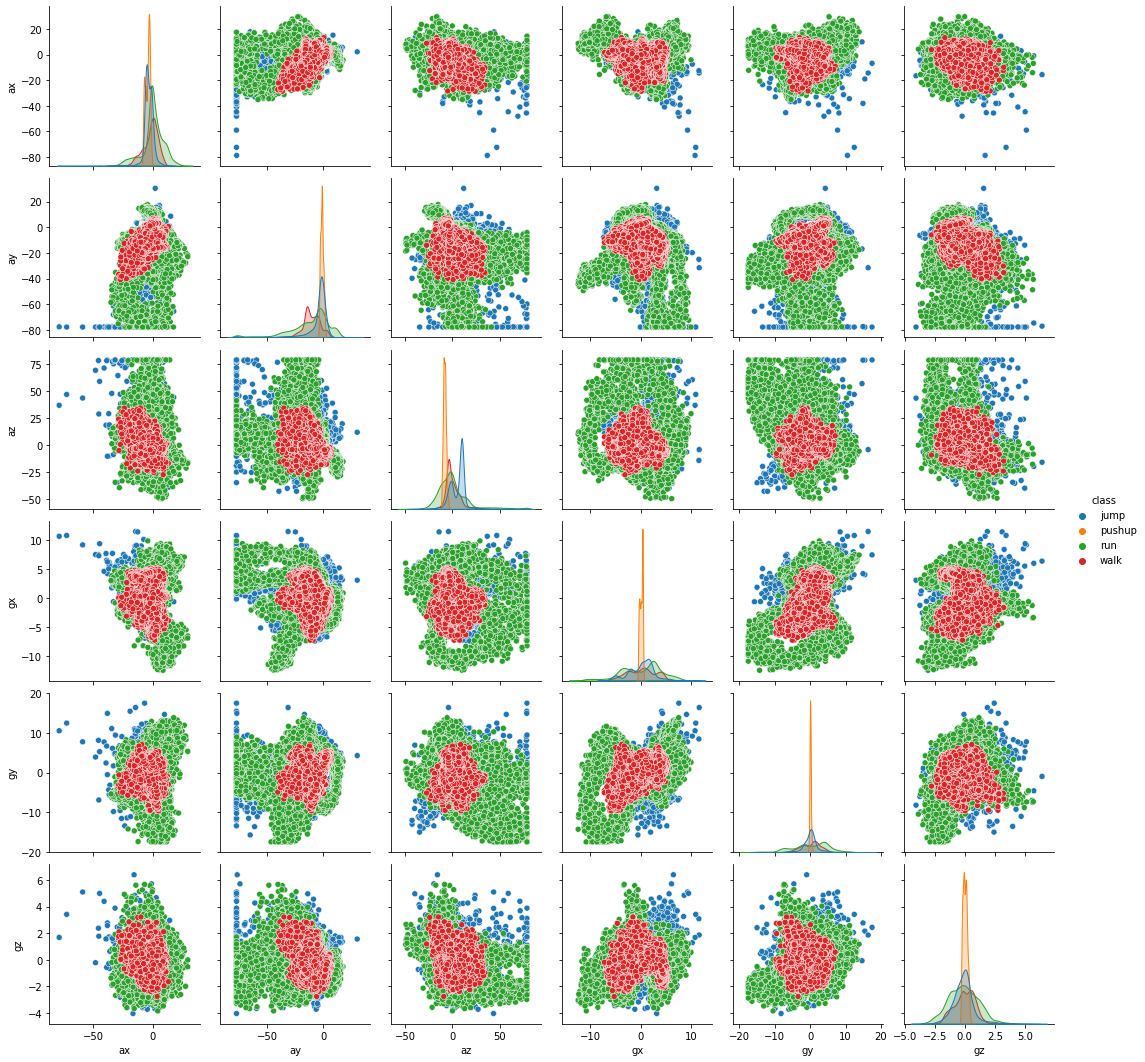

In [349]:
entire_set = pd.concat([X_train, y_train], axis=1)
sns.pairplot(entire_set, hue='class')

array(['jump', 'pushup', 'run', 'walk'], dtype=object)

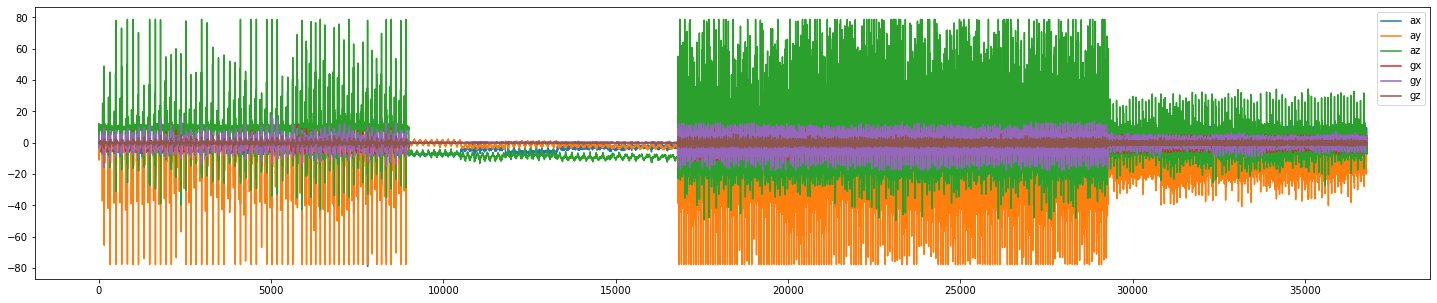

In [532]:
X_train.plot(figsize=(25,5))
y_train['class'].unique()

In [533]:
X_train.corr()

,ax,ay,az,gx,gy,gz
ax,1.000000,0.112912,-0.143663,-0.060233,0.139642,-0.017511
ay,0.112912,1.000000,-0.222017,0.000366,0.067945,-0.076872
az,-0.143663,-0.222017,1.000000,0.030260,-0.177900,-0.133600
gx,-0.060233,0.000366,0.030260,1.000000,0.402570,0.230079
gy,0.139642,0.067945,-0.177900,0.402570,1.000000,0.264381
gz,-0.017511,-0.076872,-0.133600,0.230079,0.264381,1.000000


In [488]:
knn = train_knn(X_train, y_train)

Best k:	 {'n_neighbors': 4}
Score:	 0.9687771739130435


In [489]:
print_conf_matrix(X_train, y_train, knn)

['jump' 'pushup' 'run' 'walk']
[[ 8865     0    71    64]
 [    0  7800     0     0]
 [   58     0 12321   121]
 [   94     7    91  7308]]


In [490]:
accuracy_score(y_train, knn.predict(X_train))

0.98625

In [491]:
print_conf_matrix(X_test, y_test, knn)

['jump' 'pushup' 'run' 'walk']
[[ 935   58  188  619]
 [   0   17  832 1151]
 [ 745   55 2461  239]
 [ 330   67  509  594]]


In [492]:
accuracy_score(y_test, knn.predict(X_test))

0.4553409090909091

* <b>Which features seems most useful?</b>

<b>Not scaled data</b>

Acc and gyro data:
    - Accuracy train: 0.97 test: 0.88

Acc data:
    - Accuracy train: 0.84 test: 0.77

Gyro data:
    - Accuracy train: 0.83 test: 0.73

Mag data:
    - Accuracy train: 0.86 test: 0.56

Mag data seems to bring little more info to the table and is dropped in further work.<br>
Using both acc and gyro gives better results.


<b>Scaled data using StandardScaler</b>

Acc and gyro data:
    - Accuracy train: 0.98 test: 0.88

The scaling does not seem to do any difference to the result and can be ommitted.


* <b>Can you explain the results in your confusion matrix?</b>

Confusion matrix from test set with all acc and gyro data:<br>
'jump' 'pushup' 'run' 'walk'<br>
&nbsp;1320   24  272  184<br>
&nbsp;&nbsp;   0 2000    0    0<br>
&nbsp;&nbsp; 515   10 2311  664<br>
&nbsp;&nbsp;  71   15  256 1158

It seems like run and walk is more correlated and is harder for the classifier to classify. Also, jump is more confused with run. This all looks very logical as these movements are more similar in real life.

## Preprocess the data

* <b>Sampling frequency. Should you keep 100 Hz? How do solve this with the magnetometer? What sampling frequency is needed for the classification?</b>

Referencing the tests done previously the magnetometer values are not relevant to use, thus the sampling frequency is no longer an issue.

* <b>Calculate the standard statistical values for each recording and each feature. Use (.decide()) for example. Try to explain the results you get.</b>

<b>Stddev</b>

<b>Acc: </b>Stddev is larger with more bumpy movement:<br>
<b>Move: x,y,z</b><br>
Jump: 3,11,9<br>
Pushup: 1,1,1<br>
Run: 10,19,18<br>
Walk: 7,7,7

<b>Mag: </b>Magnetometer or gyro does not give the same stddev spread.

In [551]:
raw_data_filepaths = get_filepaths_from_folder('data/cleaned/acc_mag_gyro/train/', filter='acc')

About 200 datapoints seems to be enough for stddev to close in on the "real" stddev taken with > 1000 datapoints. Far lesser (about 50) datapoints is enough for higher frequency movement, such as walking and running, but push ups and jumping takes more datapoints to give a better value of stddev. A whole movement cycle is needed to obtain the correct stddev for any of the four classes.

In [552]:
df = read_csv(raw_data_filepaths[0], [1,2,3], ['x','y','z'])
df[0:200].describe()

,x,y,z
count,200.000000,200.000000,200.000000
mean,-2.839901,-5.197945,6.638121
std,2.982411,9.838848,7.324821
min,-10.578968,-65.379690,-11.162817
25%,-4.584349,-4.211742,0.640977
50%,-3.089433,-2.049752,8.467302
75%,-1.478465,-1.107802,10.021815
max,17.922540,6.612266,48.918865


* <b>Decide if you need to scale the data or not. Which scaler do you choose? What do you expect from the choice? Better or worse result? Motivate your answer.</b>

<b>Not scaled data</b>

Acc and gyro data:
    - Accuracy train: 0.97 test: 0.88

<b>Scaled data using StandardScaler</b>

Acc and gyro data:
    - Accuracy train: 0.98 test: 0.88
    The StandardScaler does not seem to do any difference to the result and can be ommitted.

<b>Scaled data using MinMaxScaler</b>

Acc and gyro data:
    - Accuracy train: 0.99 test: 0.46
    The MinMaxScaler significantly decreases the result on the test set and can be omitted.

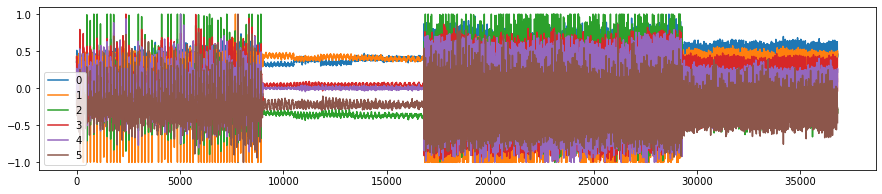

In [486]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler((-1,1)).fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_train = pd.DataFrame(X_train_scaled)
X_train.plot(figsize=(15,3))

scaler = MinMaxScaler((-1,1)).fit(X_test)
X_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled)

* <b>Transform the the acceleration to magnitude and angle. Keep this as a separate dataframe for future evaluation, i.e. classification</b>

* <b>Investigate if you can use some statistical measure for each class for classification purposes.</b>
* <b>Examine the frequency the pattern of your movements repeats itself for the different movements. Could this be helpful for the classification?</b>

See above. (Calculate the standard statistical values for each recording and each feature. Use (.decide()) for example. Try to explain the results you get.)

## Correlation

* <b>Calculate the correlation matrix between all features. From this result, discuss if all features are useful for the classification</b>

<pre>
<b>Jump</b>
Acc  x/y = 0.23
Gyro x/z = 0.38
     y/z = 0.28

<b>Pushup</b>
Acc  x/y = -0.76
     x/z = 0.59
     y/z = -0.75
Gyro x/y = -0.55
     x/z = -0.89
     y/z = 0.73

<b>Run</b>
Acc  y/z = -0.24
Gyro x/y = 0.41
     x/z = 0.24
     y/z = 0.27

<b>Walk</b>
Acc  x/y = 0.40
     x/z = -0.36
     y/z = -0.30
Gyro x/y = 0.55

In [574]:
raw_data_filepaths = get_filepaths_from_folder('data/cleaned/acc_mag_gyro/train/', filter='gyro')
#raw_data_filepaths

In [575]:
df = read_csv(raw_data_filepaths[15], [1,2,3], ['x','y','z'])
df.corr()

,x,y,z
x,1.000000,0.548701,0.033867
y,0.548701,1.000000,-0.091399
z,0.033867,-0.091399,1.000000


* <b>Calculate the autocorrelation for all classes. Do you see a pattern? Explain what you see.</b>